## Neural Style Transfer in PyTorch

Following this paper: https://arxiv.org/pdf/1508.06576v2.pdf

In [1]:
from PIL import Image
import torch
from torch import nn, optim
from torchvision import transforms, models, utils
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

%%matplotlib inline

UsageError: Line magic function `%%matplotlib` not found.


In [2]:
class VGG_19(nn.Module):
    def __init__(self):
        super(VGG_19, self).__init__()
        # using VGG 19 as per the paper
        # layers after 28 is not needed
        self.model = models.vgg19(pretrained=True).features[:30]

        # replacing all MaxPool with AvgPool
        # indexing them to replace AvgPool with same parameters
        for i, _ in enumerate(self.model):
            if i in [4, 9, 18, 27]:
                self.model[i] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        features = []
        # indices of ConV layers after AvgPool
        for i, layer in enumerate(self.model):
            x = layer(x)
            if i in [0, 5, 10, 19, 28]:
                features.append(x)
        return features

In [3]:
def load_img(img_path, img_size):
    transform = transforms.Compose(
        [transforms.Resize((img_size, img_size)), transforms.ToTensor()]
    )
    img = Image.open(img_path)
    img = transform(img).unsqueeze(0)
    return img

In [4]:
def transfer_style(
    iterations,
    optimizer,
    alpha,
    beta,
    generated_image,
    content_image,
    style_image,
    show_image=False,
):
    torch.cuda.empty_cache()
    for iter in tqdm(range(iterations + 1)):
        generated_features = model(generated_image)
        content_features = model(content_image)
        style_features = model(style_image)

        content_loss = 0.0
        style_loss = 0.0

        for generated_feature, content_feature, style_feature in zip(
            generated_features, content_features, style_features
        ):
            batch_size, n_feature_maps, height, width = generated_feature.size()
            # in the paper it is 1/2*((g-c)**2)
            # it is easier because we do not have to worry about dimensions
            content_loss += torch.mean((generated_feature - content_feature) ** 2)
            # batch_size is one so it is not needed
            # is included however for better understanding
            G = torch.mm(
                (generated_feature.view(batch_size * n_feature_maps, height * width)),
                (
                    generated_feature.view(batch_size * n_feature_maps, height * width)
                ).t(),
            )
            A = torch.mm(
                (style_feature.view(batch_size * n_feature_maps, height * width)),
                (style_feature.view(batch_size * n_feature_maps, height * width)).t(),
            )

            ###########################
            # difference from the paper
            ###########################
            E_l = (G - A) ** 2
            # w_l: one divided by the number of active layers with a non-zero loss-weight
            # directly from the paper
            w_l = 1 / 5
            style_loss += torch.mean(w_l * E_l)

        # there is little difference in changing the alpha/beta values
        total_loss = alpha * content_loss + beta * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if iter % 100 == 0:
            print("-" * 15)
            print(
                f"Iterations: {iter} \nTotal Loss: {total_loss.item()} \nContent Loss: {content_loss} \t Style Loss: {style_loss}"
            )
            print("-" * 15)

            # show image
            if show_image:
                plt.figure(figsize=(10, 10))
                plt.imshow(
                    generated_image.permute(0, 2, 3, 1)[0].cpu().detach().numpy()
                )
                plt.show()

    return generated_image

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
CONTENT_PATH = "dog.jpg"
STYLE_PATH = "style.jpg"

content_img = load_img(CONTENT_PATH, 512).to(device)
style_img = load_img(STYLE_PATH, 512).to(device)
model = VGG_19().to(device)
for param in model.parameters():
    param.requires_grad = False

In [7]:
# generated image (init) is the content image or noise
# requires_grad is set to True because the network itself is frozen
generated_init = content_img.clone().requires_grad_(True)

iterations = 500
lr = 1e-2
alpha, beta = 1, 1

optimizer = optim.Adam([generated_init], lr=lr)

  0%|          | 0/501 [00:00<?, ?it/s]---------------
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Iterations: 0 
Total Loss: 18249874.0 
Content Loss: 0.0 	 Style Loss: 18249874.0
---------------


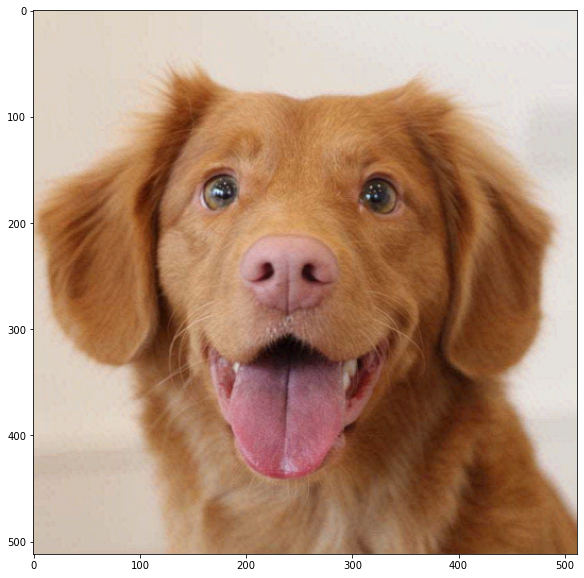

  3%|▎         | 14/501 [00:19<11:04,  1.36s/it]


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 4.00 GiB total capacity; 2.38 GiB already allocated; 52.20 MiB free; 2.54 GiB reserved in total by PyTorch) (malloc at ..\c10\cuda\CUDACachingAllocator.cpp:289)
(no backtrace available)

In [24]:
%%timeit

started_time = datetime.datetime.now()
generated_image = transfer_style(
    iterations=iterations,
    optimizer=optimizer,
    alpha=alpha,
    beta=beta,
    generated_image=generated_init,
    content_image=content_img,
    style_image=style_img,
    show_image=True,
)
elapsed_time = datetime.datetime.now() - started_time

In [ ]:
elapsed_time

In [ ]:
# utils.save_image(generated_image, 'output.png')